## NeurIPS Paramater Count analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-20 16:46:54.179104: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 16:46:55.224177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 16:46:55.669047: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 16:46:55.670202: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *
from collections import defaultdict

Resorting genes by reference genome order


#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 12.4%
RAM Usage: 6.8%
Available RAM: 938.5G
Total RAM: 1007.0G
52.4G


## Wandb API Query <a id="sims"></a>

Data load

In [5]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from models.feature_based import ExponentialDecayModel, GaussianKernelModel, CGEModel
from models.bilinear import BilinearCM, BilinearLowRank
from models.dynamic_mlp import DynamicMLP
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# Load data
print("Loading data...")

gene_list = '0.2'

# Load gene expression data
X, valid_genes = load_transcriptome(parcellation='S456', gene_list=gene_list, hemisphere='both', omit_subcortical=False, sort_genes='expression', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_pca = load_transcriptome(parcellation='S456', gene_list=gene_list, hemisphere='both', omit_subcortical=False, sort_genes='expression', impute_strategy='mirror_interpolate', run_PCA='95var')

Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# prepare data loaders
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")

# Create dataset
dataset = TensorDataset(X, coords)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

Loading data...
Resorting genes by expression level
Resorting genes by expression level
Number of components for 95% variance PCA: 27


In [6]:
from data.data_utils import RegionPairDataset

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))
# Create pairwise dataset
print("Creating pairwise dataset...")

# Create pairwise dataset
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    dataset='UKBB', 
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes
)

print(f"Dataset: {len(dataset)} region pairs")

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Creating pairwise dataset...
Dataset: 206570 region pairs


In [7]:
# Initialize models with best parameters for each gene list

# Bilinear CM full
bilinear_full = BilinearCM(
    input_dim=X_valid.shape[1]*2,
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    bias=True,
    closed_form=True
).to('cuda')

# Bilinear CM pca
bilinear_full = BilinearCM(
    input_dim=X_pca.shape[1]*2,
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    bias=True,
    closed_form=True
).to('cuda')

# Bilinear CM pls
bilinear_full = BilinearCM(
    input_dim=10*2,
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    bias=True,
    closed_form=True
).to('cuda')

# Bilinear Lowrank
bilinear_lr_full = BilinearLowRank(
    input_dim=X_valid.shape[1]*2,
    activation='none', 
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    shared_weights=True,
    reduced_dim=10
).to('cuda')

# Shared Transformer (only for full gene list)
shared_transformer_full = SharedSelfAttentionModel(
    input_dim=X_valid.shape[1]*2,
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    use_alibi=True,
    nhead=4,
    num_layers=4,
    deep_hidden_dims=[512, 256, 128],
    transformer_dropout=0.2,
    dropout_rate=0.2,
    learning_rate=0.00009,
    weight_decay=0.0001
).to('cuda')

# Dynamic MLP
dynamic_mlp_full = DynamicMLP(
    input_dim=X_valid.shape[1]*2,
    hidden_dims=[512, 256, 128],
    learning_rate=0.00009,
    batch_size=512,
    dropout_rate=0.1,
    weight_decay=0.0001
).to('cuda')

Total number of learnable parameters in BilinearCMmodel: 54464401


  warnings.warn(



Total number of learnable parameters in BilinearCMmodel: 730
Total number of learnable parameters in BilinearCMmodel: 101
Number of learnable parameters in Bilinear low rank model: 73800
  Linear layer 1: 73800 parameters
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in MLP: 7723777


In [9]:
def fetch_and_summarize_wandb_runs(model, cv_type, null_model, gene_list='0.2', feature_type='transcriptome', target='FC', within_last=60, before_last=0, use_weighted=False, exclude='HCP', return_history=False):
    """
    Fetches wandb runs matching specific tags and summarizes their final train/test metrics.
    Handles different CV types with their expected number of runs:
    - random/spatial: 40 runs
    - schaefer: 9 runs  
    - lobe: 6 runs
    
    Args:
        model (str): Model name, e.g., 'bilinear_CM'
        cv_type (str): CV type, one of: 'random', 'spatial', 'schaefer', 'lobe'
        null_model (str): Null model label, e.g., 'none'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        target (str): Target connectome type, e.g., 'FC'
        within_last (int): Search for runs within this many days ago (default: 60)
        before_last (int): Exclude runs from this many days ago (default: 0)
        use_weighted (bool): Whether to compute weighted statistics for schaefer/lobe CV
        exclude (str): Dataset to exclude from search (default: 'HCP')
        return_history (bool): If True, return (summary_df, history_df) tuple
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
                                  If use_weighted=True and cv_type in ['schaefer', 'lobe'], 
                                  includes weighted_mean and weighted_stderr rows
        history_df (pd.DataFrame): Individual run data (only returned if return_history=True)
    """
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Set expected number of runs based on cv_type
    if cv_type == "schaefer":
        expected_runs = 9
    elif cv_type == "lobe":
        expected_runs = 6
    else:  # random or spatial
        expected_runs = 40
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"target_{target}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}",
                f"gene_list_{gene_list}"  # Fixed: Removed comma and added proper string formatting
            ],
        },
        "created_at": {
            "$gte": start_time.isoformat(), 
            "$lte": end_time.isoformat()
        },
        "state": "finished"
    }
    
    # Add exclusion filter if specified
    if exclude != "":
        filters["tags"]["$nin"] = [f"dataset_{exclude}"]
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        # Extract fold number for weighted calculations
        if use_weighted and cv_type in ['schaefer', 'lobe']:
            fold_match = re.search(r'fold(\d+)', run.name)
            if fold_match:
                metrics['fold'] = int(fold_match.group(1))
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    print(f"📊 Found {len(df)} total runs")

    if len(df) < expected_runs:
        raise ValueError(f"❌ Expected {expected_runs} runs, but found {len(df)}.")

    # Handle deduplication based on CV type
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        # Sort by fold number for proper weight assignment
        df = df.sort_values('fold')
        # Deduplicate by fold keeping highest test pearson_r within each fold
        df_unique = (
            df.sort_values(["fold", "final_test_pearson_r"], ascending=[True, False])
              .drop_duplicates("fold", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique folds, found {len(df_unique)} after deduplication.")
    else:
        # Deduplicate by run_name using highest test pearson_r
        df_unique = (
            df.sort_values("final_test_pearson_r", ascending=False)
              .drop_duplicates("run_name", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique run names, found {len(df_unique)} after deduplication.")

    # Store history before cleaning for aggregation
    history_df = df_unique.copy()
    
    # Clean and summarize
    columns_to_drop = ["run_name", "run_id", "final_test_pearson_r"]
    if 'fold' in df_unique.columns:
        columns_to_drop.append("fold")
    df_clean = df_unique.drop(columns=columns_to_drop, errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T
    
    # Add weighted statistics if requested and applicable
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        weights = list(CV_WEIGHTS[cv_type].values())
        
        # Calculate weighted statistics for final_test_pearson_r
        weighted_mean, weighted_se = weighted_mean_and_se(df_unique['final_test_pearson_r'].values, weights)
        summary_df.loc['weighted_mean', 'final_test_pearson_r'] = weighted_mean
        summary_df.loc['weighted_stderr', 'final_test_pearson_r'] = weighted_se
        
        # Calculate weighted statistics for test_pearson_r if it exists
        if 'test_pearson_r' in df_clean.columns:
            test_pearson_values = df_unique['test_pearson_r'].values if 'test_pearson_r' in df_unique.columns else df_clean['test_pearson_r'].values
            weighted_mean_test, weighted_se_test = weighted_mean_and_se(test_pearson_values, weights)
            summary_df.loc['weighted_mean', 'test_pearson_r'] = weighted_mean_test
            summary_df.loc['weighted_stderr', 'test_pearson_r'] = weighted_se_test

    if return_history:
        return summary_df, history_df
    else:
        return summary_df

In [10]:
# Global parameters for spatial CV
cv_type = 'random'

# Create dictionary to store random results
random_results = {}

# Exponential Decay
within_last, before_last = 120, 0
random_results['exponential_decay'] = fetch_and_summarize_wandb_runs('exponential_decay', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='euclidean', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM full
within_last, before_last = 120, 0
random_results['bilinear_cm'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM PCA
within_last, before_last = 120, 0
random_results['bilinear_cm_pca'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome_PCA', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM PLS
within_last, before_last = 120, 0
random_results['bilinear_cm_pls'] = fetch_and_summarize_wandb_runs('pls_bilineardecoder', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear lowrank full
within_last, before_last = 120, 0 
random_results['bilinear_lowrank_full'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Shared transformer full
within_last, before_last = 7, 2
random_results['shared_transformer_full'] = fetch_and_summarize_wandb_runs('shared_transformer', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP full
within_last, before_last = 7, 2
random_results['dynamic_mlp_full'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 41 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


📊 Found 41 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 44 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 122 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 148 total runs
📊 After deduplication: 40 unique runs


In [11]:
# Global parameters for spatial CV
cv_type = 'spatial'

# Create dictionary to store spatial results
spatial_results = {}

# Exponential Decay
within_last, before_last = 120, 0
spatial_results['exponential_decay'] = fetch_and_summarize_wandb_runs('exponential_decay', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='euclidean', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM
within_last, before_last = 120, 0
spatial_results['bilinear_cm'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM PCA
within_last, before_last = 120, 0
spatial_results['bilinear_cm_pca'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome_PCA', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM PLS
within_last, before_last = 120, 0
spatial_results['bilinear_cm_pls'] = fetch_and_summarize_wandb_runs('pls_bilineardecoder', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)


# Bilinear lowrank full
within_last, before_last = 120, 0 
spatial_results['bilinear_lowrank_full'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Shared transformer full
within_last, before_last = 7, 2
spatial_results['shared_transformer_full'] = fetch_and_summarize_wandb_runs('shared_transformer', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP full
within_last, before_last = 7, 2
spatial_results['dynamic_mlp_full'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


📊 Found 120 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
📊 Found 112 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 84 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 82 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 148 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found

In [ ]:
import matplotlib.ticker as ticker

def plot_param_count_vs_performance(random_results, spatial_results, metric='test_long_r'):
    # Print test metrics for each model
    print("\nRandom Split Test Metrics:")
    print("-" * 50)
    for model_key in random_results.keys():
        print(f"{model_key}: {metric} = {random_results[model_key].loc['mean', metric]:.4f}")
        
    print("\nSpatial Split Test Metrics:") 
    print("-" * 50)
    for model_key in spatial_results.keys():
        print(f"{model_key}: {metric} = {spatial_results[model_key].loc['mean', metric]:.4f}")

    # Create figure with two subplots with higher DPI
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
    
    # Dictionary to store parameter counts for each model
    param_counts = {
        'exponential_decay': 2,
        #'bilinear_cm': 54464401,
        #'bilinear_cm_pca': 730,
        'bilinear_cm_pls': 101,
        'bilinear_lowrank_full': 73800,
        'shared_transformer_full': 2162315,
        'dynamic_mlp_full': 7723777
    }
    
    # Model name mapping for abbreviated labels
    model_names = {
        'exponential_decay': 'Exp. \nDecay',
        'bilinear_cm': 'Bilinear CM',
        'bilinear_cm_pca': 'Bilinear CM \n(PCA)',
        'bilinear_cm_pls': 'Bilinear CM \n(PLS)',
        'bilinear_lowrank_full': 'Bilinear \nLow-rank',
        'shared_transformer_full': 'SMT',
        'dynamic_mlp_full': 'MLP'
    }

    # Model type mapping
    model_types = {
        'exponential_decay': 'rules_based',
        'bilinear_cm': 'bilinear',
        'bilinear_cm_pca': 'bilinear',
        'bilinear_cm_pls': 'bilinear', 
        'bilinear_lowrank_full': 'bilinear',
        'shared_transformer_full': 'deep_learning',
        'dynamic_mlp_full': 'deep_learning'
    }
    
    # Colors for each model type
    type_colors = {
        'rules_based': sns.color_palette("viridis", n_colors=12, desat=1.0)[10],
        'bilinear': sns.color_palette("viridis", n_colors=12, desat=1.0)[6],
        'deep_learning': sns.color_palette("viridis", n_colors=12, desat=1.0)[2]
    }
    
    # Global parameters for visualization
    MARKER_SIZE = 15
    FONT_SIZE = 17
    LEGEND_MARKER_SIZE = MARKER_SIZE * 1.2  # Slightly larger markers in legend
    
    # Plot for random CV
    for model_key in random_results.keys():
        if model_key in param_counts:
            x = param_counts[model_key]
            y = random_results[model_key].loc['mean', metric]
            model_type = model_types[model_key]
            color = type_colors[model_type]
            ax1.plot(x, y, 'o', color=color, markersize=MARKER_SIZE)
            ax1.annotate(model_names[model_key], (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=FONT_SIZE)

    # Map metric names to display names
    metric_display_names = {
        'test_pearson_r': 'Pearson-r',
        'test_mse': 'Mean-Squared Error',
        'test_long_r': 'Long-range Pearson-r',
        'test_short_r': 'Short-range Pearson-r',
        'test_strong_pos_r': 'Strong Pos. Edge Pearson-r',
        'test_strong_neg_r': 'Strong Neg. Edge Pearson-r',
        'geodesic': 'Geodesic Distance'
    }
    
    display_metric = metric_display_names.get(metric, metric)

    # Configure x-axis with manual log scale ticks
    ax1.set_xscale('log')
    # Define major tick locations (powers of 10)
    major_ticks = [10**i for i in range(0, 9)]

    # Define minor tick locations (between major ticks)
    minor_ticks = []
    for i in range(len(major_ticks)-1):
        # Add 2,3,4,5,6,7,8,9 times the current power of 10
        for j in range(2, 10):
            minor_ticks.append(j * major_ticks[i])

    # Set the major and minor tick locators
    ax1.set_xticks(major_ticks)
    ax1.set_xticks(minor_ticks, minor=True)

    # Configure grid
    ax1.grid(True, which="major", color="0.9", linewidth=1.0)
    #ax1.grid(True, which="minor", color="0.95", linewidth=0.5)
    
    # Get min and max y values from the data
    y_values = [random_results[model_key].loc['mean', metric] 
                for model_key in random_results.keys() if model_key in param_counts]
    ymin, ymax = min(y_values), max(y_values)
    margin = (ymax - ymin) * .2
    ax1.set_ylim(ymin - margin, ymax + margin)
    
    # Format y-axis to remove leading zeros
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.2f}'.lstrip('0')))
    
    ax1.set_xlabel('Number of Parameters (log scale)')
    ax1.set_ylabel(f'{display_metric}')
    ax1.set_title('Random Split Performance vs Learnable Parameters')

    # Plot for spatial CV
    for model_key in spatial_results.keys():
        if model_key in param_counts:
            x = param_counts[model_key]
            y = spatial_results[model_key].loc['mean', metric]
            # y = np.round(y, -int(np.floor(np.log10(abs(y)))) + 1)
            model_type = model_types[model_key]
            color = type_colors[model_type]
            ax2.plot(x, y, 'o', color=color, markersize=MARKER_SIZE)
            ax2.annotate(model_names[model_key], (x, y), xytext=(-15, 10),
                        textcoords='offset points', fontsize=FONT_SIZE)

    # Configure x-axis with manual log scale ticks
    ax2.set_xscale('log')
    # Define major tick locations (powers of 10)
    major_ticks = [10**i for i in range(0, 9)]

    # Define minor tick locations (between major ticks)
    minor_ticks = []
    for i in range(len(major_ticks)-1):
        # Add 2,3,4,5,6,7,8,9 times the current power of 10
        for j in range(2, 10):
            minor_ticks.append(j * major_ticks[i])

    # Set the major and minor tick locators
    ax2.set_xticks(major_ticks)
    ax2.set_xticks(minor_ticks, minor=True)

    # Configure grid
    ax2.grid(True, which="major", color="0.9", linewidth=1.0)
    #ax2.grid(True, which="minor", color="0.95", linewidth=0.5)
   # Get min and max y values from the data
    y_values = [spatial_results[model_key].loc['mean', metric] 
                for model_key in spatial_results.keys() if model_key in param_counts]
    ymin, ymax = min(y_values), max(y_values)
    margin = (ymax - ymin) * .2
    ax2.set_ylim(ymin - margin, ymax + margin)
    
    # Format y-axis to remove leading zeros
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.2f}'.lstrip('0')))
    
    ax2.set_xlabel('Number of Parameters (log scale)')
    ax2.set_ylabel(f'{display_metric}')
    ax2.set_title('Spatial Split Performance vs Learnable Parameters')
    
    # Create legend with colored markers and scaled properties
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=type_colors['rules_based'], 
                   label='Rules-based', markersize=LEGEND_MARKER_SIZE),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=type_colors['bilinear'],
                   label='Bilinear', markersize=LEGEND_MARKER_SIZE),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=type_colors['deep_learning'],
                   label='Deep Learning', markersize=LEGEND_MARKER_SIZE)
    ]
    ax2.legend(handles=legend_elements, loc='lower right', fontsize=FONT_SIZE)

    plt.tight_layout()
    
    plt.show()


Random Split Test Metrics:
--------------------------------------------------
exponential_decay: test_pearson_r = 0.3464
bilinear_cm: test_pearson_r = 0.6174
bilinear_cm_pca: test_pearson_r = 0.5062
bilinear_cm_pls: test_pearson_r = 0.7202
bilinear_lowrank_full: test_pearson_r = 0.7725
shared_transformer_full: test_pearson_r = 0.7933
dynamic_mlp_full: test_pearson_r = 0.7810

Spatial Split Test Metrics:
--------------------------------------------------
exponential_decay: test_pearson_r = 0.4408
bilinear_cm: test_pearson_r = 0.4560
bilinear_cm_pca: test_pearson_r = 0.4232
bilinear_cm_pls: test_pearson_r = 0.6051
bilinear_lowrank_full: test_pearson_r = 0.6685
shared_transformer_full: test_pearson_r = 0.7162
dynamic_mlp_full: test_pearson_r = 0.7212


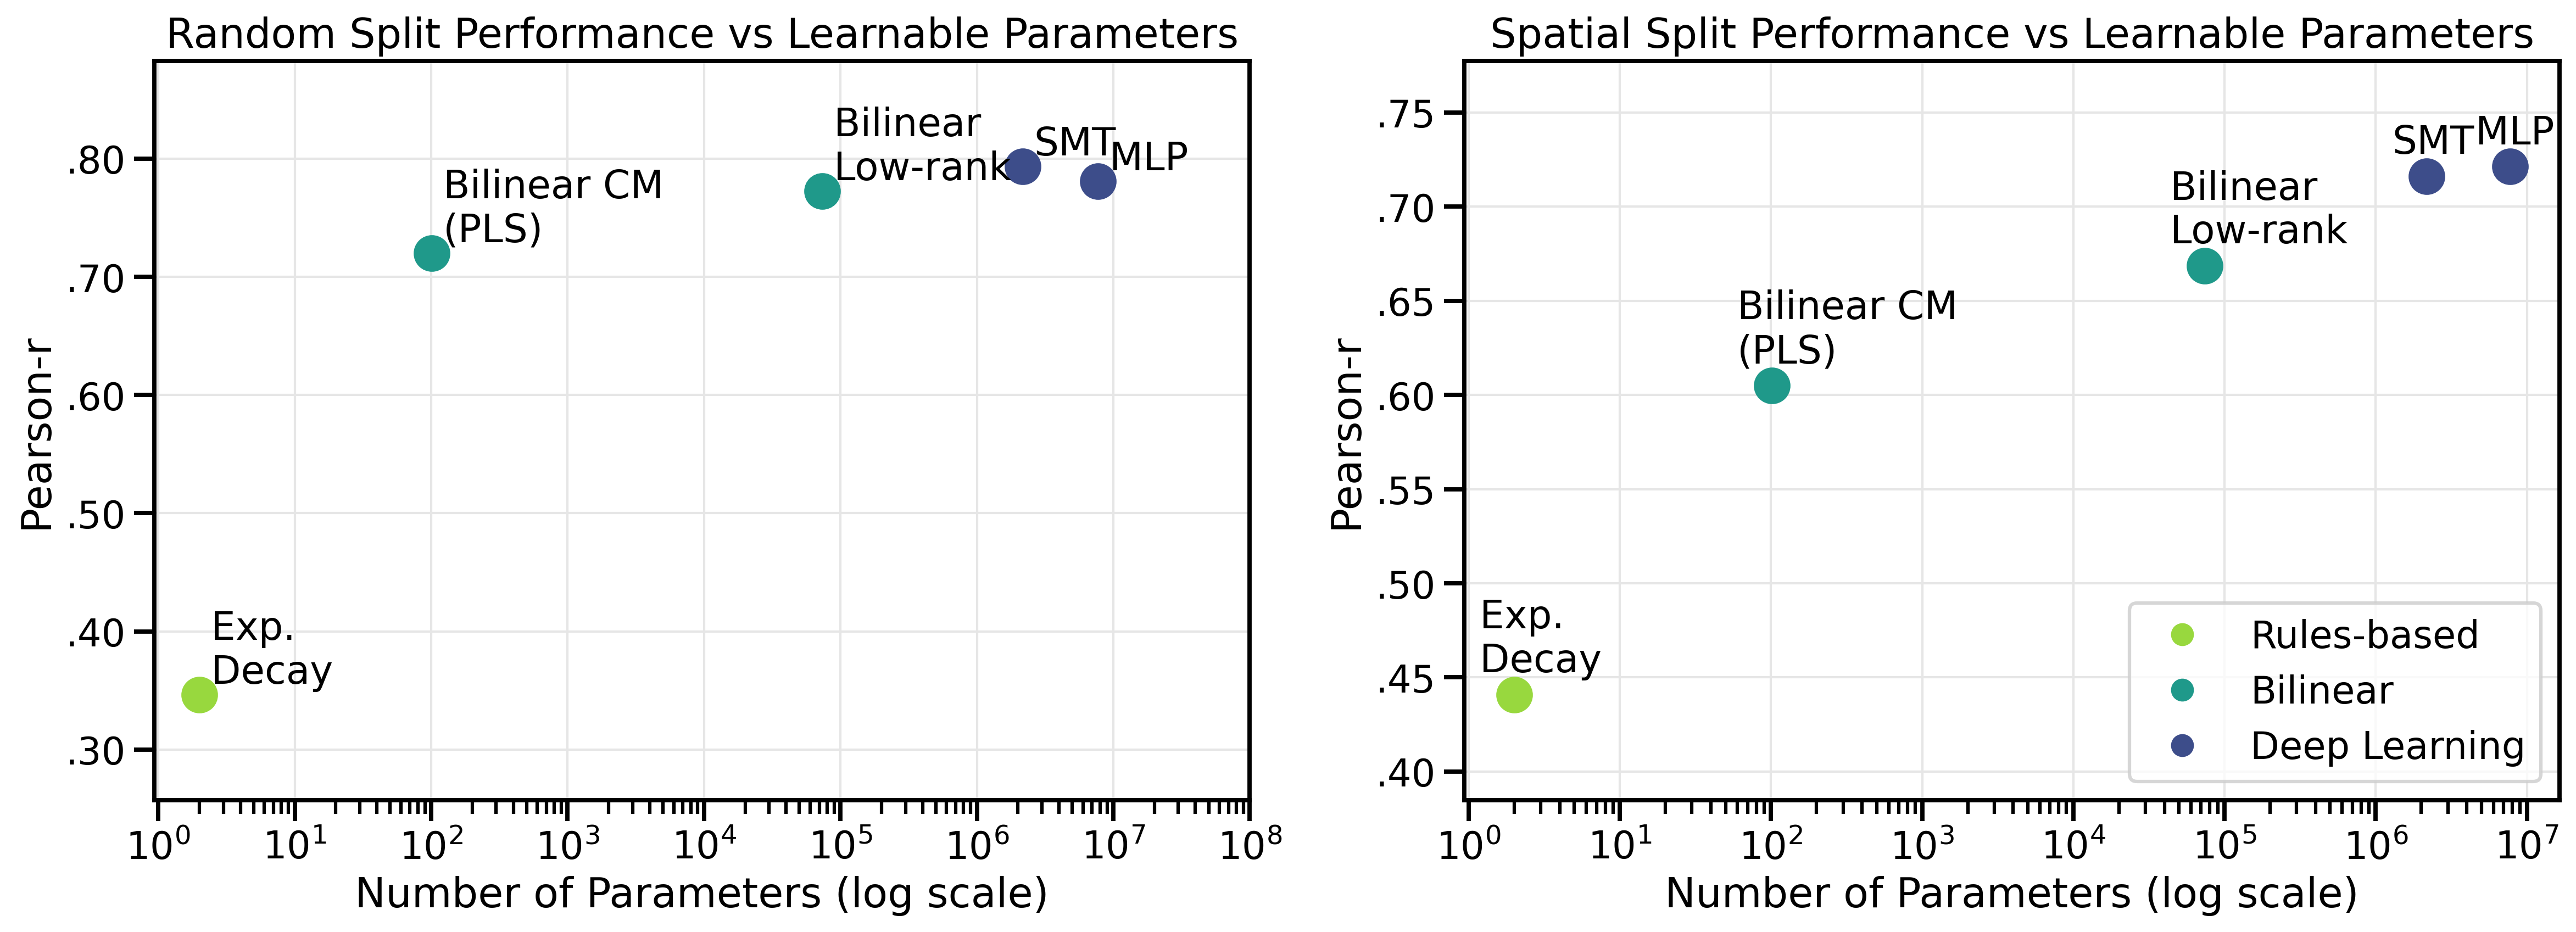

In [21]:
plot_param_count_vs_performance(random_results, spatial_results, metric='test_pearson_r')


Random Split Test Metrics:
--------------------------------------------------
exponential_decay: test_mse = 0.0296
bilinear_cm: test_mse = 0.0300
bilinear_cm_pca: test_mse = 0.0255
bilinear_cm_pls: test_mse = 0.0161
bilinear_lowrank_full: test_mse = 0.0135
shared_transformer_full: test_mse = 0.0128
dynamic_mlp_full: test_mse = 0.0137

Spatial Split Test Metrics:
--------------------------------------------------
exponential_decay: test_mse = 0.0359
bilinear_cm: test_mse = 0.0731
bilinear_cm_pca: test_mse = 0.0753
bilinear_cm_pls: test_mse = 0.0275
bilinear_lowrank_full: test_mse = 0.0242
shared_transformer_full: test_mse = 0.0223
dynamic_mlp_full: test_mse = 0.0232


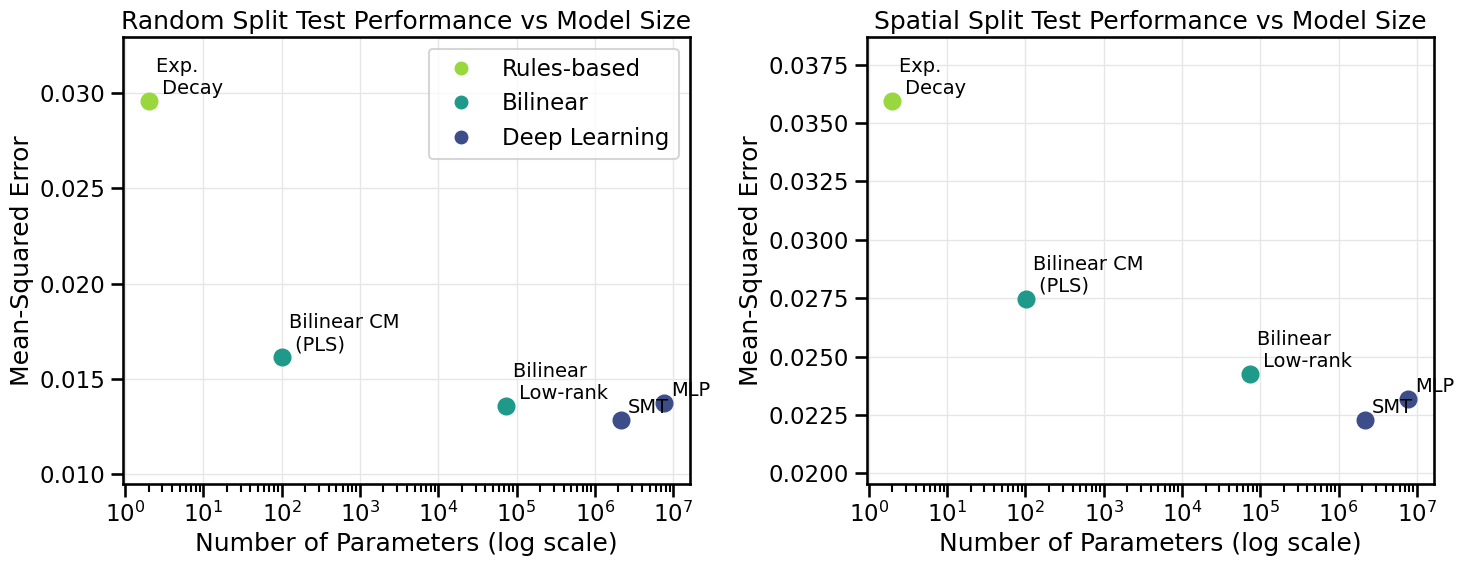

In [165]:
plot_param_count_vs_performance(random_results, spatial_results, metric='test_mse')
